<a href="https://colab.research.google.com/github/buisonanh/customer_segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prepare data**

In [ ]:
import pandas as pd
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the transactional data
transactions_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/customer-transactions.csv")
items_df = pd.read_csv("/content/drive/MyDrive/DA20 - Final Project/Unsupervised Learning/items.csv")

print(transactions_df.head())
print(items_df.head())

In [ ]:
print(transactions_df.isnull().sum())
print(items_df.isnull().sum())

In [ ]:
# Identify duplicate rows
print(f'Number of duplicates (transactions_df): {transactions_df.duplicated().sum()}')
print(f'Number of duplicates (items_df): {items_df.duplicated().sum()}')

In [ ]:
# Perform a left join on the ItemID column to add the SellPrice column to the transactions_df
transactions_df = pd.merge(transactions_df, items_df[['ItemID', 'SellPrice']], on='ItemID', how='left')

# Print the updated transactions dataframe
print(transactions_df.head())


   OrderID  CustomerID  ItemID TransactionDate   Channel  SellPrice
0        0           0     352      2020-03-21  In Store        735
1        0           0    3433      2020-07-14  In Store        963
2        0           0   11162      2020-08-09  In Store        582
3        0           0   13011      2020-12-07  In Store        339
4        0           0   13885      2020-11-08  In Store       1369


In [ ]:
print(transactions_df.info())
print()
print(items_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25213 entries, 0 to 25212
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   OrderID          25213 non-null  int64         
 1   CustomerID       25213 non-null  int64         
 2   ItemID           25213 non-null  int64         
 3   TransactionDate  25213 non-null  datetime64[ns]
 4   Channel          25213 non-null  object        
 5   SellPrice        25213 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.3+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17889 entries, 0 to 17888
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ItemID     17889 non-null  int64 
 1   Product    17889 non-null  object
 2   Brand      17889 non-null  object
 3   SellPrice  17889 non-null  int64 
 4   CostPrice  17889 non-null  int64 
dtypes: int6

# **Calculate RFM Score**

In [ ]:
# Convert the TransactionDate column to a datetime object
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Calculate the Recency, Frequency, and Monetary values for each customer
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (dt.datetime.today() - recency_df['TransactionDate']).dt.days
recency_df.drop('TransactionDate', axis=1, inplace=True)

frequency_df = transactions_df.groupby('CustomerID')['OrderID'].nunique().reset_index()
frequency_df.rename(columns={'OrderID': 'Frequency'}, inplace=True)

monetary_df = transactions_df.groupby('CustomerID')['SellPrice'].sum().reset_index()
monetary_df.rename(columns={'SellPrice': 'Monetary'}, inplace=True)

# Merge the Recency, Frequency, and Monetary dataframes
rfm_df = pd.merge(recency_df, frequency_df, on='CustomerID')
rfm_df = pd.merge(rfm_df, monetary_df, on='CustomerID')



rfm_df.drop(columns=['CustomerID'], inplace=True)

# Print the RFM dataframe
print(rfm_df.head())

   Recency  Frequency  Monetary
0      868         15     32997
1      876         14     34948
2      880          7     17879
3      871          6     14603
4      869         14     37029


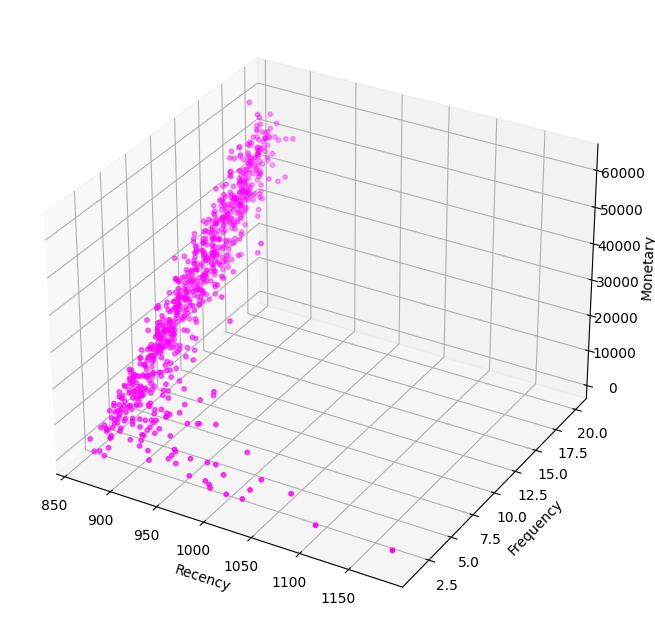

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

x = rfm_df['Recency']
y = rfm_df['Frequency']
z = rfm_df['Monetary']

ax.scatter(x, y, z, c='magenta' ,s=10)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()


# **Scale Data**

In [ ]:
X = rfm_df.iloc[:].values
X

array([[  868,    15, 32997],
       [  876,    14, 34948],
       [  880,     7, 17879],
       ...,
       [  865,    19, 45470],
       [  864,    15, 35462],
       [  869,    10, 24568]])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

# **Evaluate**

In [ ]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

**Sum of Squared Errors (SSE)**

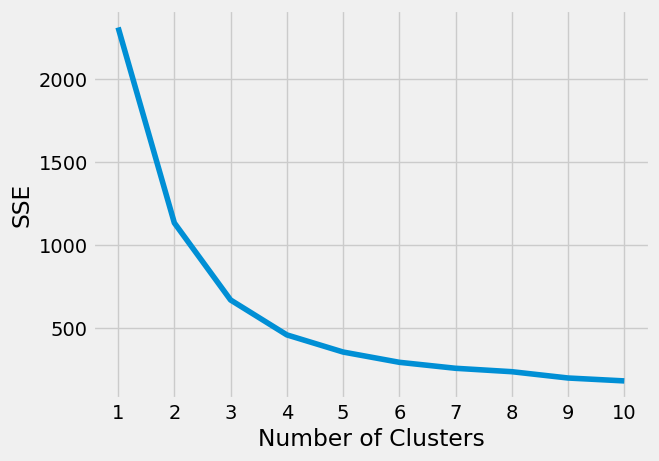

In [ ]:
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"max_iter": 300,
"random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 sse.append(kmeans.inertia_)



plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

print(f'Elbow: {kl.elbow}')

Elbow: 3


**Sillhouette**

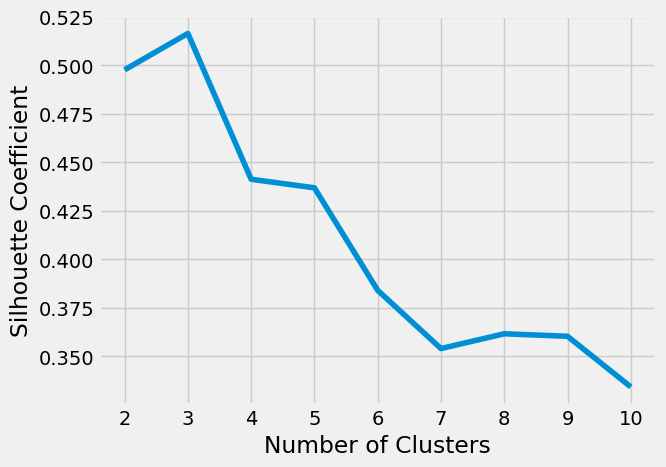

In [ ]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
 kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
 kmeans.fit(scaled_features)
 score = silhouette_score(scaled_features, kmeans.labels_)
 silhouette_coefficients.append(score)

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
import numpy as np

# Find the index of the maximum silhouette score
best_idx = np.argmax(silhouette_coefficients)

# The best number of clusters is the index plus 2 (because we started at 2 clusters)
best_n_clusters = best_idx + 2

print(f"The best number of clusters is {best_n_clusters}")


The best number of clusters is 3


# **Model (K-Mean Clustering)**

### 3 clusters

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
import plotly.express as px

# Create a DataFrame with the RFM scores and cluster labels
df = pd.DataFrame(X, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = y_kmeans
df['Cluster'] = df['Cluster'].astype('str')

# Create the plot
fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.8, size_max=1, height=1000)

fig.show()



### 4 clusters

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
import plotly.express as px

# Create a DataFrame with the RFM scores and cluster labels
df = pd.DataFrame(X, columns=['Recency', 'Frequency', 'Monetary'])
df['Cluster'] = y_kmeans
df['Cluster'] = df['Cluster'].astype('str')

# Create the plot
fig = px.scatter_3d(df, x='Recency', y='Frequency', z='Monetary',
                    color='Cluster', opacity=0.8, size_max=1, height=1000)

fig.show()

